                         Date  Distance (km)  Avg Heartrate  Time (minutes)
108 2024-10-07 13:33:56+00:00        10.0257          161.4       42.250000
109 2024-10-08 16:18:15+00:00         5.0137          151.6       21.850000
110 2024-10-10 17:29:17+00:00         5.0099          157.7       19.366667
111 2024-10-11 16:57:56+00:00         4.0095          148.9       15.783333
112 2024-10-11 17:18:36+00:00         4.0218          164.1       17.283333
113 2024-10-13 08:00:14+00:00        10.3405          167.6       42.916667
114 2024-10-17 11:33:43+00:00         4.0210          164.9       17.566667
115 2024-10-18 12:01:43+00:00         5.0211          161.0       21.383333
116 2024-10-19 10:34:53+00:00         4.0000          158.3       15.916667
117 2024-10-19 16:57:18+00:00         4.0074          142.6       17.083333


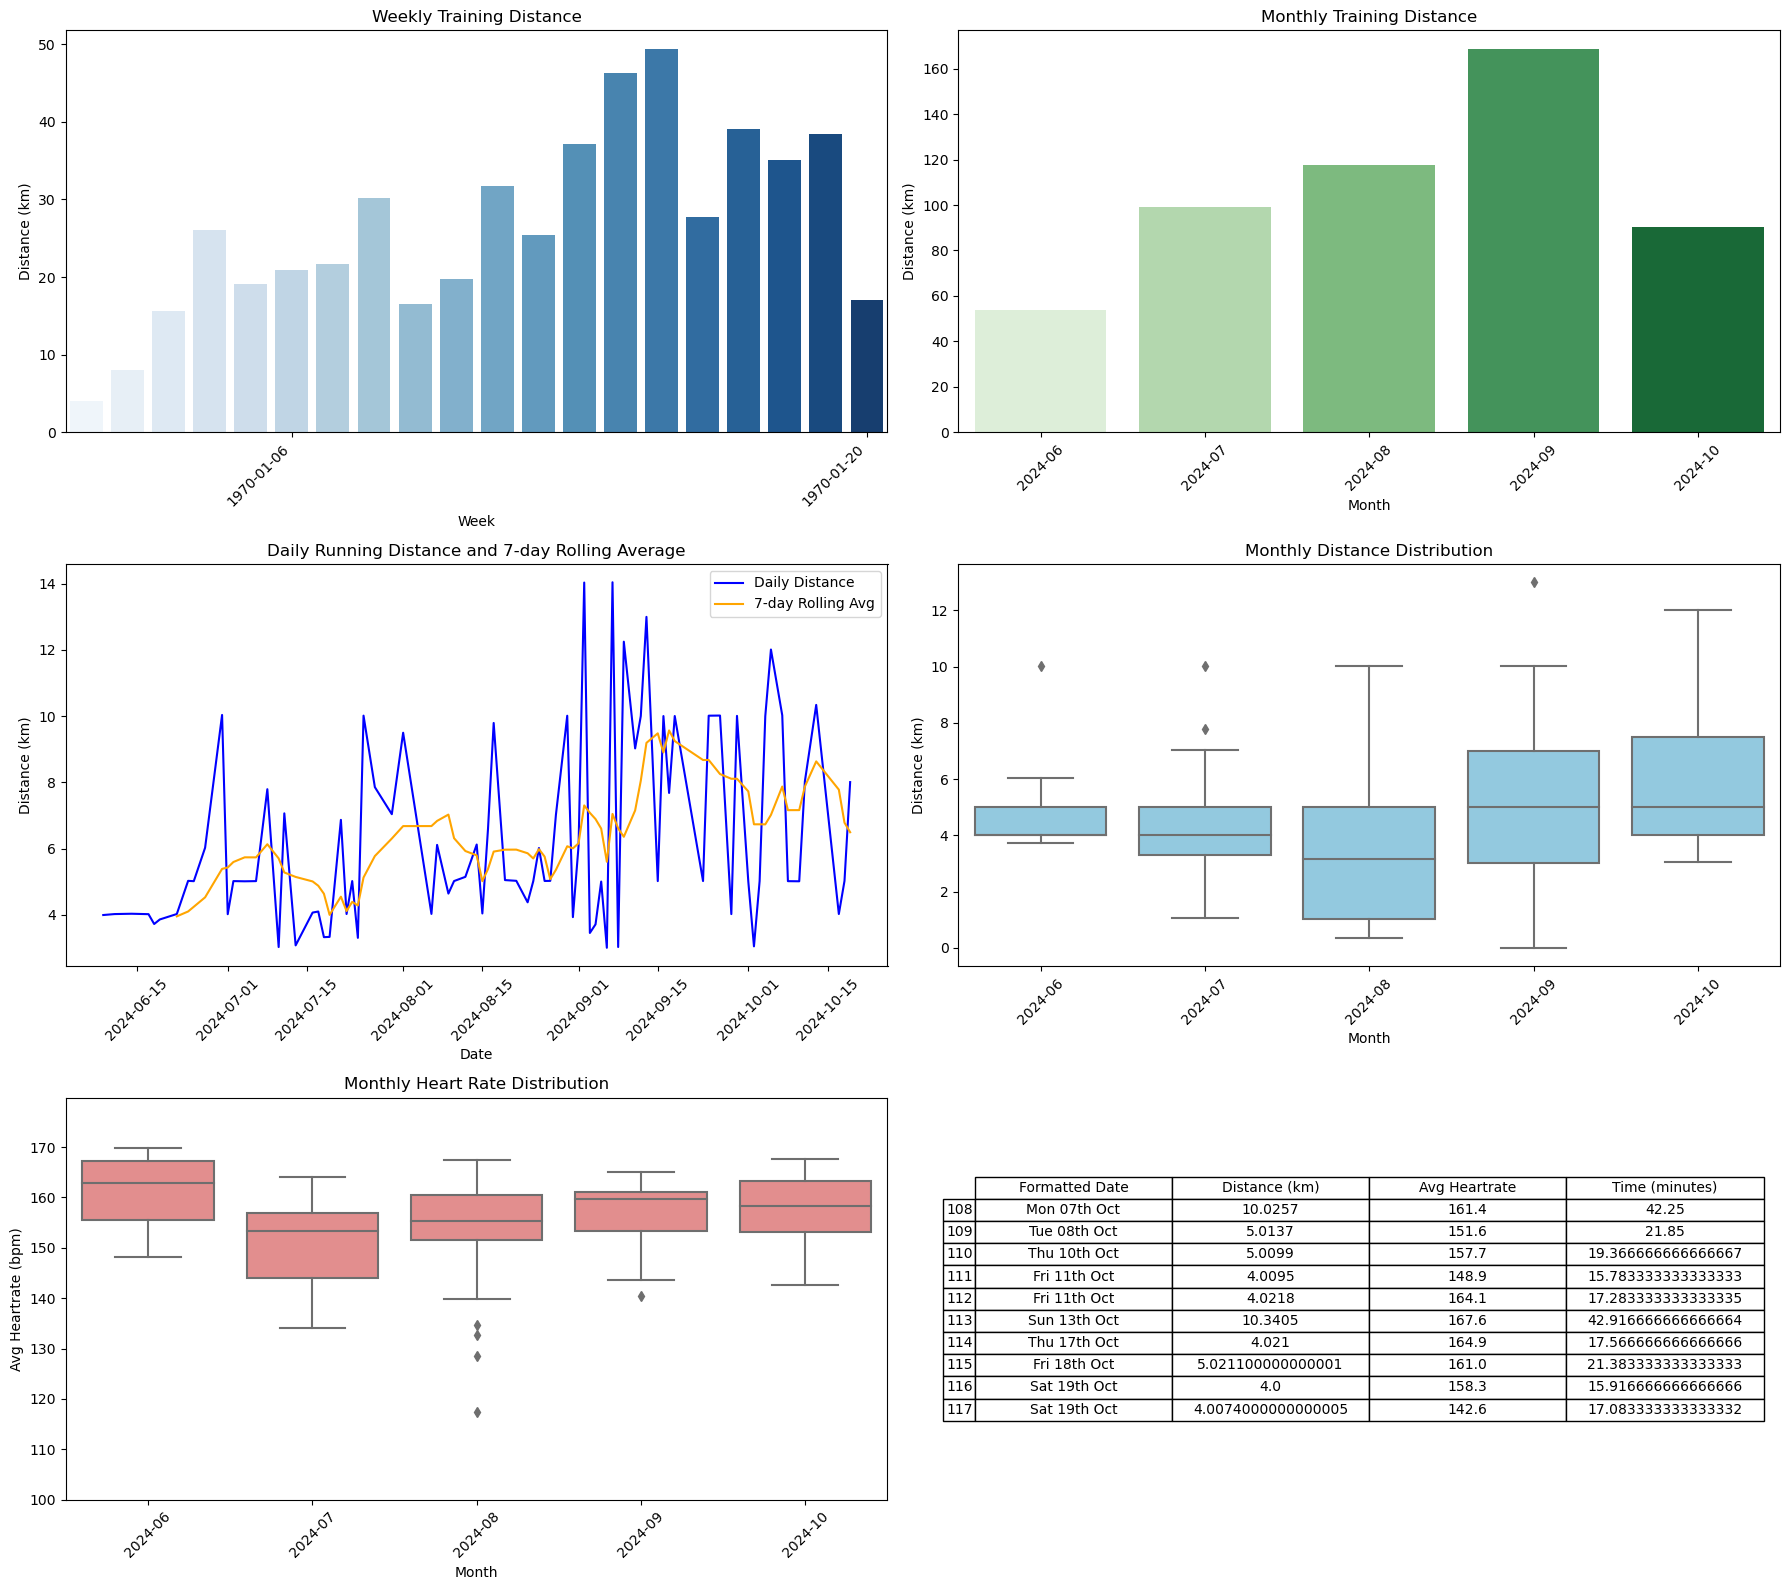

In [60]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from datetime import datetime
import matplotlib.dates as mdates
from pandas.plotting import table

# Initial Setup
client_id = '132964'
client_secret = 'edd5dac7aa72b54840e924a0d558961508cb631a'
refresh_token = '9777a200f3d024ff4026f54b3e4d10f69f99ba2c'  # Replace with your latest refresh token

# Function to refresh the access token
def refresh_access_token(refresh_token, client_id, client_secret):
    refresh_response = requests.post(
        url='https://www.strava.com/oauth/token',
        data={
            'client_id': client_id,
            'client_secret': client_secret,
            'grant_type': 'refresh_token',
            'refresh_token': refresh_token
        }
    )

    if refresh_response.status_code == 200:
        new_tokens = refresh_response.json()
        with open('refresh_token.txt', 'w') as f:
            f.write(new_tokens['refresh_token'])
        return new_tokens['access_token'], new_tokens['refresh_token']
    else:
        raise Exception("Failed to refresh access token: " + refresh_response.text)

# Load refresh token from a file if it exists
if os.path.exists('refresh_token.txt'):
    with open('refresh_token.txt', 'r') as f:
        refresh_token = f.read().strip()

# Refresh the access token
try:
    access_token, refresh_token = refresh_access_token(refresh_token, client_id, client_secret)
except Exception as e:
    print(e)
    exit()

# Function to fetch activities from Strava API
def fetch_activities(access_token, start_date):
    headers = {'Authorization': f'Bearer {access_token}'}
    response = requests.get(
        'https://www.strava.com/api/v3/athlete/activities',
        headers=headers,
        params={'after': start_date, 'per_page': 200}
    )

    if response.status_code == 200:
        activities = response.json()
        return pd.DataFrame(activities)
    else:
        print("Failed to get activities:", response.json())
        return pd.DataFrame()

# Fetch all activities since June 1, 2024
start_date = int(time.mktime(time.strptime('2024-06-01', '%Y-%m-%d')))
df_activities = fetch_activities(access_token, start_date)

# If no activities found, exit
if df_activities.empty:
    print("No activities found.")
    exit()

# Extract and rename necessary columns
df_activities = df_activities[['start_date', 'distance', 'moving_time', 'average_heartrate']]
df_activities.rename(columns={
    'start_date': 'Date',
    'distance': 'Distance (meters)',
    'moving_time': 'Time (seconds)',
    'average_heartrate': 'Avg Heartrate'
}, inplace=True)

# Convert units where necessary
df_activities['Distance (km)'] = df_activities['Distance (meters)'] / 1000
df_activities['Time (minutes)'] = df_activities['Time (seconds)'] / 60
df_activities['Date'] = pd.to_datetime(df_activities['Date']).dt.tz_convert('UTC')

# Filter data from June 2024 onwards
df_activities = df_activities[df_activities['Date'] >= '2024-06-01']

# Display the last 10 sessions
last_30_sessions = df_activities[['Date', 'Distance (km)', 'Avg Heartrate', 'Time (minutes)']].tail(10)
print(last_30_sessions)

# Convert 'Date' column to naive datetime (remove timezone info) before converting to periods
df_activities['Week'] = df_activities['Date'].dt.tz_localize(None).dt.to_period('W').apply(lambda r: r.start_time)
df_activities['Month'] = df_activities['Date'].dt.tz_localize(None).dt.to_period('M')

# Weekly distance
weekly_distance = df_activities.groupby('Week')['Distance (km)'].sum().reset_index()

# Monthly distance
monthly_distance = df_activities.groupby('Month')['Distance (km)'].sum().reset_index()

# Format the 'Date' column in the table
last_30_sessions['Formatted Date'] = pd.to_datetime(last_30_sessions['Date']).dt.strftime('%a %dth %b')

# Only keep the formatted date column for the table
table_data = last_30_sessions[['Formatted Date', 'Distance (km)', 'Avg Heartrate', 'Time (minutes)']]

# Create and save all plots in a single grid function
def save_and_display_grid_plots():
    # Create a 3x2 grid for the plots (6 total plots)
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))

    # Bar plot for weekly distance (Top-left)
    sns.barplot(data=weekly_distance, x='Week', y='Distance (km)', palette='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Weekly Training Distance')
    axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

    # Format the x-axis for weeks
    axes[0, 0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))  # Show every 2nd week
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as Year-Month-Day

    # Bar plot for monthly distance (Top-right)
    sns.barplot(data=monthly_distance, x='Month', y='Distance (km)', palette='Greens', ax=axes[0, 1])
    axes[0, 1].set_title('Monthly Training Distance')
    axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

    # Line plot for daily distance and rolling average (Middle-left)
    df_activities['Date'] = df_activities['Date'].dt.date
    df_daily_distance = df_activities.groupby('Date')['Distance (km)'].sum().reset_index()
    df_daily_distance['7-day Rolling Avg (km)'] = df_daily_distance['Distance (km)'].rolling(window=7).mean()

    axes[1, 0].plot(df_daily_distance['Date'], df_daily_distance['Distance (km)'], label='Daily Distance', color='blue')
    axes[1, 0].plot(df_daily_distance['Date'], df_daily_distance['7-day Rolling Avg (km)'], label='7-day Rolling Avg', color='orange')
    axes[1, 0].set_title('Daily Running Distance and 7-day Rolling Average')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Distance (km)')
    axes[1, 0].legend()
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Boxplot for distance per month (Middle-right)
    sns.boxplot(x='Month', y='Distance (km)', data=df_activities, ax=axes[1, 1], color='skyblue')
    axes[1, 1].set_title('Monthly Distance Distribution')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

    # Remove outliers from 'Avg Heartrate' column
    df_activities_filtered = df_activities[df_activities['Avg Heartrate'] >= 100]

    # Boxplot for average heart rate per month (Bottom-left)
    sns.boxplot(x='Month', y='Avg Heartrate', data=df_activities_filtered, ax=axes[2, 0], color='lightcoral')
    axes[2, 0].set_title('Monthly Heart Rate Distribution')
    axes[2, 0].set_xticklabels(axes[2, 0].get_xticklabels(), rotation=45)
    axes[2, 0].set_ylabel('Avg Heartrate (bpm)')
    axes[2, 0].set_ylim(100, df_activities_filtered['Avg Heartrate'].max() + 10)  # Set y-axis start at 100

    # Display the formatted last 30 sessions as a table (Bottom-right)
    axes[2, 1].axis('off')  # Turn off the axis for the table
    tbl = table(axes[2, 1], table_data, loc='center', cellLoc='center', colWidths=[0.2]*len(table_data.columns))
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)  # Adjust the scale of the table

    # Adjust layout
    plt.tight_layout()

    # Save the entire grid as one plot
    plt.savefig('training_summary_grid_with_table.png')

    # Display the plot
    plt.show()

# Generate and display/save plots in a grid
save_and_display_grid_plots()